# Wyckoff using Machine Learning


✅ Accuracy: 0.92
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        85
           1       0.89      0.53      0.67        15

    accuracy                           0.92       100
   macro avg       0.91      0.76      0.81       100
weighted avg       0.92      0.92      0.91       100



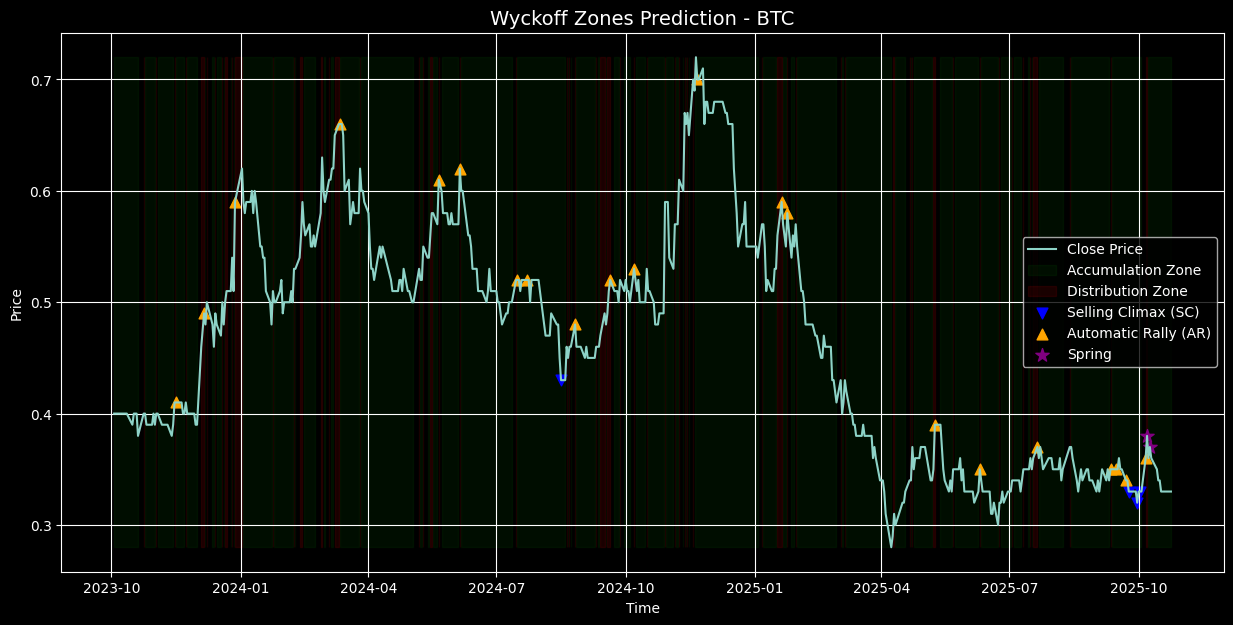

In [30]:
from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


# ===================================================
# 1️⃣ ดึงข้อมูลจาก Cassandra
# ===================================================
def get_candlestick_data(symbol: str, limit: int = 100):
    try:
        cluster = Cluster(['127.0.0.1'], port=9042)
        session = cluster.connect('stock_data')

        query = """
            SELECT time, open_price, high_price, low_price, close_price, volume
            FROM candlestick_data
            WHERE symbol = %s
            ORDER BY time DESC
            LIMIT %s
        """
        rows = session.execute(query, (symbol, limit))
        df = pd.DataFrame(list(rows))

        if df.empty:
            print(f"⚠️ ไม่พบข้อมูลสำหรับ symbol '{symbol}'")
            return pd.DataFrame()

        df.rename(columns={
            'open_price': 'open',
            'high_price': 'high',
            'low_price': 'low',
            'close_price': 'close'
        }, inplace=True)

        df.sort_values('time', inplace=True)
        df.reset_index(drop=True, inplace=True)

        return df

    except Exception as e:
        raise ConnectionRefusedError(f"❌ ไม่สามารถเชื่อมต่อ Cassandra ได้: {e}")

    finally:
        try:
            cluster.shutdown()
        except:
            pass


# ===================================================
# 2️⃣ สร้าง Wyckoff Feature Engineering
# ===================================================
def wyckoff_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """
    สร้างฟีเจอร์ตามหลัก Wyckoff เพื่อใช้ใน Machine Learning
    """
    df = df.copy()

    df['price_change'] = df['close'].pct_change()
    df['volume_change'] = df['volume'].pct_change()
    df['high_low_spread'] = (df['high'] - df['low']) / df['close']
    df['close_position'] = (df['close'] - df['low']) / (df['high'] - df['low'] + 1e-6)

    df['ma_20'] = df['close'].rolling(20).mean()
    df['ma_50'] = df['close'].rolling(50).mean()
    df['volume_ma_20'] = df['volume'].rolling(20).mean()

    df['effort_vs_result'] = df['volume'] * df['price_change']
    df['supply_demand_ratio'] = df['volume_change'] / (df['price_change'] + 1e-6)
    df['above_ma'] = (df['close'] > df['ma_20']).astype(int)

    window = 20
    df['local_min'] = df['low'][(df['low'] == df['low'].rolling(window, center=True).min())]
    df['local_max'] = df['high'][(df['high'] == df['high'].rolling(window, center=True).max())]

    # จุด Wyckoff สำคัญแบบ heuristic
    df['SC'] = ((df['local_min'].notnull()) & (df['volume'] > df['volume_ma_20'] * 1.5)).astype(int)
    df['AR'] = ((df['local_max'].notnull()) & (df['volume'] > df['volume_ma_20'] * 1.2)).astype(int)
    df['Spring'] = ((df['SC'].shift(5) == 1) & (df['close'] > df['ma_20'])).astype(int)

    df.fillna(0, inplace=True)
    return df


# ===================================================
# 3️⃣ สร้างโมเดล Machine Learning จำแนกเฟส Wyckoff
# ===================================================
def train_wyckoff_model(df: pd.DataFrame):
    df = df.copy()

    # Label แบบง่าย: 0 = Accumulation, 1 = Distribution
    df['label'] = np.where(
        (df['volume'] > df['volume_ma_20']) & (df['price_change'] < 0.001), 0,
        np.where((df['volume'] > df['volume_ma_20']) & (df['price_change'] >= 0.001), 1, 0)
    )

    features = ['price_change', 'volume_change', 'high_low_spread',
                'close_position', 'effort_vs_result', 'supply_demand_ratio', 'above_ma']

    X = df[features]
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n✅ Accuracy: {acc:.2f}")
    print(classification_report(y_test, y_pred))

    df['predicted_label'] = model.predict(X)

    return model, df


# ===================================================
# 4️⃣ Visualization Wyckoff Zones
# ===================================================
def plot_wyckoff_zones(df: pd.DataFrame, symbol: str):
    plt.figure(figsize=(15, 7))
    plt.plot(df['time'], df['close'], label='Close Price', linewidth=1.5)

    # โซน Accumulation/Distribution จากโมเดล
    plt.fill_between(df['time'], df['close'].min(), df['close'].max(),
                     where=(df['predicted_label'] == 0),
                     color='green', alpha=0.1, label='Accumulation Zone')
    plt.fill_between(df['time'], df['close'].min(), df['close'].max(),
                     where=(df['predicted_label'] == 1),
                     color='red', alpha=0.1, label='Distribution Zone')

    # จุดสำคัญ Wyckoff
    plt.scatter(df.loc[df['SC'] == 1, 'time'], df.loc[df['SC'] == 1, 'close'],
                color='blue', label='Selling Climax (SC)', marker='v', s=60)
    plt.scatter(df.loc[df['AR'] == 1, 'time'], df.loc[df['AR'] == 1, 'close'],
                color='orange', label='Automatic Rally (AR)', marker='^', s=60)
    plt.scatter(df.loc[df['Spring'] == 1, 'time'], df.loc[df['Spring'] == 1, 'close'],
                color='purple', label='Spring', marker='*', s=100)


    plt.title(f"Wyckoff Zones Prediction - {symbol}", fontsize=14)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


# ===================================================
# 🚀 MAIN PIPELINE
# ===================================================
if __name__ == "__main__":
    symbol = "BTC"
    df = get_candlestick_data(symbol, limit=500)
    if df.empty:
        print("ไม่มีข้อมูลจาก Cassandra")
    else:
        df = wyckoff_feature_engineering(df)
        model, df = train_wyckoff_model(df)
        plot_wyckoff_zones(df, symbol)
